In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import bz2
import _pickle as cPickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from statsmodels.stats.proportion import proportions_ztest

In [2]:
current_dir = Path.cwd()
relative_path = 'data/compressed_noadjusted.pbz2'
frame_path = current_dir.joinpath(relative_path)
shot_frame = bz2.BZ2File(str(frame_path), 'rb')
shot_frame = cPickle.load(shot_frame)

In [3]:
pd.set_option('display.max_columns', None)
shot_frame.head()

,game_id_livefeed,season,type,game_time,away_code,home_code,venue,period,period_ord,period_type,time_elapsed,cum_time_elapsed,event,event_team_code,event_team_is_home,event_coord_x,event_coord_y,secondary_type,is_rebound,strength,time_remaining,seconds_remaining,skaters_a,skaters_h,goalie_pulled_a,goalie_pulled_h,shot_dist,event_zone,miss_type,shot_type,calc_dist,dist_difference,players_h,players_a,fwds_h,fwds_a,calc_angle,players_shooting,skaters_shooting,fwds_shooting,attacker_state
0,2010020003,20102011,R,2010-10-07T16:00:00Z,CAR,MIN,Hartwall Areena,1,1st,REGULAR,01:05,65.0,SHOT,CAR,False,56.0,-15.0,Snap Shot,False,EV,18:55,1135.0,5,5,False,False,37.0,Off. Zone,Save,Snap,36.249138,0.750862,6,6,3,3,-24.443955,6,5,3,5-on-5
1,2010020003,20102011,R,2010-10-07T16:00:00Z,CAR,MIN,Hartwall Areena,1,1st,REGULAR,01:16,76.0,MISS,CAR,False,35.0,33.0,None,False,EV,18:44,1124.0,5,5,False,False,64.0,Off. Zone,Wide of Net,Wrist,63.285069,0.714931,6,6,3,3,31.429566,6,5,3,5-on-5
2,2010020003,20102011,R,2010-10-07T16:00:00Z,CAR,MIN,Hartwall Areena,1,1st,REGULAR,01:37,97.0,MISS,MIN,True,87.0,-6.0,None,False,EV,18:23,1103.0,5,5,False,False,6.0,Off. Zone,Wide of Net,Wrist,6.324555,0.324555,6,6,3,3,-71.565051,6,5,3,5-on-5
3,2010020003,20102011,R,2010-10-07T16:00:00Z,CAR,MIN,Hartwall Areena,1,1st,REGULAR,03:33,213.0,GOAL,MIN,True,78.0,3.0,Wrist Shot,False,EV,16:27,987.0,5,5,False,False,12.0,Off. Zone,Goal,Wrist,11.401754,0.598246,6,6,3,3,15.255119,6,5,3,5-on-5
4,2010020003,20102011,R,2010-10-07T16:00:00Z,CAR,MIN,Hartwall Areena,1,1st,REGULAR,03:49,229.0,BLOCK,MIN,True,77.0,13.0,None,False,EV,16:11,971.0,5,5,False,False,NaN,Off. Zone,Block,Snap,17.691806,NaN,6,6,3,3,47.290610,6,5,3,5-on-5


In [4]:
shot_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428115 entries, 0 to 1428367
Data columns (total 41 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   game_id_livefeed    1428115 non-null  object 
 1   season              1428115 non-null  object 
 2   type                1428115 non-null  object 
 3   game_time           1428115 non-null  object 
 4   away_code           1428115 non-null  object 
 5   home_code           1428115 non-null  object 
 6   venue               1428115 non-null  object 
 7   period              1428115 non-null  int64  
 8   period_ord          1428115 non-null  object 
 9   period_type         1428115 non-null  object 
 10  time_elapsed        1428115 non-null  object 
 11  cum_time_elapsed    1428115 non-null  float64
 12  event               1428115 non-null  object 
 13  event_team_code     1428115 non-null  object 
 14  event_team_is_home  1428115 non-null  bool   
 15  event_coord_x  

The home/away features need to be re-configured to be attacking vs. defending team. For example, if the home team takes the shot, the feature `goalie_pulled_a` will indicate whether the shot is taken on an empty net while `goalie_pulled_h` indicates whether the attacking team has pulled their goalie for an extra attacker. Conventional wisdom is that either situation is more likely to lead to a goal.

The features that still need to be reframed as attacking vs defending are `skater_h`/`skaters_a` (although this is already coded in `attacker_state`

In [5]:
shot_frame['is_extra_attacker'] = np.where(shot_frame['event_team_is_home'] == True,
                                        shot_frame['goalie_pulled_h'],
                                        shot_frame['goalie_pulled_a'])
shot_frame['is_empty_net'] = np.where(shot_frame['event_team_is_home'] == True,
                                        shot_frame['goalie_pulled_a'],
                                        shot_frame['goalie_pulled_h'])

In [6]:
shot_frame['players_defending'] = np.where(shot_frame['event_team_is_home']==True,
                                            shot_frame['players_a'],
                                            shot_frame['players_h'])
shot_frame['skaters_defending'] = np.where(shot_frame['event_team_is_home']==True,
                                            shot_frame['skaters_a'],
                                            shot_frame['skaters_h'])
shot_frame['fwds_defending'] = np.where(shot_frame['event_team_is_home']==True,
                                            shot_frame['fwds_a'],
                                            shot_frame['fwds_h'])

In [7]:
shot_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428115 entries, 0 to 1428367
Data columns (total 46 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   game_id_livefeed    1428115 non-null  object 
 1   season              1428115 non-null  object 
 2   type                1428115 non-null  object 
 3   game_time           1428115 non-null  object 
 4   away_code           1428115 non-null  object 
 5   home_code           1428115 non-null  object 
 6   venue               1428115 non-null  object 
 7   period              1428115 non-null  int64  
 8   period_ord          1428115 non-null  object 
 9   period_type         1428115 non-null  object 
 10  time_elapsed        1428115 non-null  object 
 11  cum_time_elapsed    1428115 non-null  float64
 12  event               1428115 non-null  object 
 13  event_team_code     1428115 non-null  object 
 14  event_team_is_home  1428115 non-null  bool   
 15  event_coord_x  

The home/away columns have been re-coded as shooting (attacking)/defending, thus are no longer required.

In [8]:
shot_frame.drop(['goalie_pulled_a', 'goalie_pulled_h', 'skaters_a', 'skaters_h', 'players_h', 'players_a', 'fwds_h', 'fwds_a',
                'away_code', 'home_code'], axis=1, inplace=True)

In [9]:
shot_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428115 entries, 0 to 1428367
Data columns (total 36 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   game_id_livefeed    1428115 non-null  object 
 1   season              1428115 non-null  object 
 2   type                1428115 non-null  object 
 3   game_time           1428115 non-null  object 
 4   venue               1428115 non-null  object 
 5   period              1428115 non-null  int64  
 6   period_ord          1428115 non-null  object 
 7   period_type         1428115 non-null  object 
 8   time_elapsed        1428115 non-null  object 
 9   cum_time_elapsed    1428115 non-null  float64
 10  event               1428115 non-null  object 
 11  event_team_code     1428115 non-null  object 
 12  event_team_is_home  1428115 non-null  bool   
 13  event_coord_x       1428115 non-null  float64
 14  event_coord_y       1428115 non-null  float64
 15  secondary_type 

Should we drop these?

In [10]:
# shot_frame.drop(['game_id_livefeed', 'season', 'game_time', 'away_code', 'home_code', 'venue', 'period_ord', 'time_elapsed', 
#                 'event_team_code', 'seconds_remaining'], axis=1, inplace=True)

In [11]:
shot_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428115 entries, 0 to 1428367
Data columns (total 36 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   game_id_livefeed    1428115 non-null  object 
 1   season              1428115 non-null  object 
 2   type                1428115 non-null  object 
 3   game_time           1428115 non-null  object 
 4   venue               1428115 non-null  object 
 5   period              1428115 non-null  int64  
 6   period_ord          1428115 non-null  object 
 7   period_type         1428115 non-null  object 
 8   time_elapsed        1428115 non-null  object 
 9   cum_time_elapsed    1428115 non-null  float64
 10  event               1428115 non-null  object 
 11  event_team_code     1428115 non-null  object 
 12  event_team_is_home  1428115 non-null  bool   
 13  event_coord_x       1428115 non-null  float64
 14  event_coord_y       1428115 non-null  float64
 15  secondary_type 

The `strength` column should be derivable from `attacker_state` with the two columns referencing pulled goaltenders (`is_extra_attacker` and `is_empty_net`) being required for rare edge states. In particular, even strength events should almost always see the attacker strength being even (5-on-5, 4-on-4, or 3-on-3). In rare cases with a pulled goalie, the values could be off by one. Likewise, power play events should have the number of skaters for the shooting team generally be greater than the number of skaters for the defending team. Short-handed events would be the reverse.

In [12]:
shot_frame.strength.unique()

array(['EV', 'PP', 'SH'], dtype=object)

In [13]:
shot_frame[shot_frame.strength=='EV']['attacker_state'].value_counts()

5-on-5    1115039
4-on-4      28441
6-on-5      23259
3-on-3       7865
5-on-6       5672
5-on-4        940
4-on-5        275
4-on-3         58
6-on-4         45
5-on-3         13
3-on-5          9
3-on-4          4
4-on-6          2
Name: attacker_state, dtype: int64

In [14]:
shot_frame[shot_frame.strength=='PP']['attacker_state'].value_counts()

5-on-4    201268
5-on-3      7076
4-on-3      4073
6-on-4      3224
5-on-5       843
6-on-3       110
4-on-4        62
4-on-5        11
6-on-5        10
3-on-3         2
5-on-6         1
Name: attacker_state, dtype: int64

In [15]:
shot_frame[shot_frame.strength=='SH']['attacker_state'].value_counts()

4-on-5    28509
5-on-5      535
4-on-6      421
3-on-4      171
3-on-5      133
4-on-4       22
5-on-4       12
6-on-5        3
5-on-6        3
3-on-6        2
4-on-3        2
Name: attacker_state, dtype: int64

There are rare cases where there are impossible situations coded into the strength. Since the attacker state subsumes this category and there are known inconsistencies, this column can be dropped.

In [16]:
shot_frame.drop(['strength'], axis=1, inplace=True)

There are multiple indicators of shot distance. One is a distance given directly in the play-by-play (`shot_dist`) and the other is a distance calculated from the coordinates (`calc_dist`). These values are generally nearly identical, which provides additional confidence in their correctness. However, there are a number of shots where these differ by a large amount.

It is apparent that there are a considerable number of shots that are coded incorrectly in some respect.

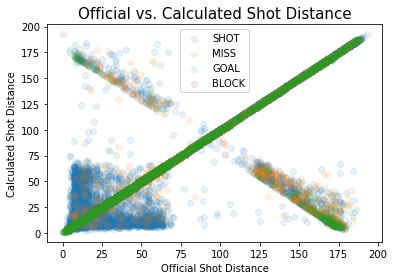

In [17]:
event_types = shot_frame.event.unique()
for event_type in event_types:
    plt.scatter(x='shot_dist', y='calc_dist', data=shot_frame[shot_frame.event==event_type], label=event_type, alpha=0.1);
plt.xlabel('Official Shot Distance');
plt.ylabel('Calculated Shot Distance');
plt.title('Official vs. Calculated Shot Distance', fontsize=15);
plt.legend();

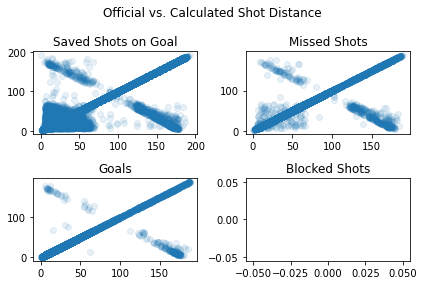

In [18]:
fig, axs = plt.subplots(2,2);
axs[0,0].scatter(x='shot_dist', y='calc_dist', data=shot_frame[shot_frame.event=='SHOT'], label=event_type, alpha=0.1);
axs[0,0].set_title('Saved Shots on Goal');
axs[0,1].scatter(x='shot_dist', y='calc_dist', data=shot_frame[shot_frame.event=='MISS'], label=event_type, alpha=0.1);
axs[0,1].set_title('Missed Shots');
axs[1,0].scatter(x='shot_dist', y='calc_dist', data=shot_frame[shot_frame.event=='GOAL'], label=event_type, alpha=0.1);
axs[1,0].set_title('Goals');
axs[1,1].scatter(x='shot_dist', y='calc_dist', data=shot_frame[shot_frame.event=='BLOCK'], label=event_type, alpha=0.1);
axs[1,1].set_title('Blocked Shots');
plt.suptitle('Official vs. Calculated Shot Distance');
fig.tight_layout()

Several observations can be drawn from the above plots. 
1. Blocked shots are totally missing (in particular, the `shot_dist` field is not present for blocked shots).
2. While the correlation is generally high, there are obviously a number of data points where the shot distances are coded as if aimed at opposing nets. The fact that there are very few mis-coded shots with length near 100 feet indicates that the issue is that the attacking zone was somehow mis-coded. In these cases, the shorter distance is likely to be the correct value.
3. There are a number of saved shots and missed shots where all of the shot distances are similar in magnitude yet there is little correlation between the shots. This may reflect the NHL scoring process, where shots can be re-evaluated after game time and shooters/locations can be corrected. The `shot_dist` field is pulled from the HTML play-by-play report which is generated immediately after the game concludes. In these cases, the live feed is likely to be correct.

In [19]:
shot_frame['dist_difference'].describe()

count    1.065985e+06
mean     7.016785e-01
std      4.940297e+00
min      0.000000e+00
25%      1.890163e-01
50%      4.383507e-01
75%      7.405933e-01
max      1.926344e+02
Name: dist_difference, dtype: float64

In [20]:
shot_frame['dist_difference'].quantile([.9, .99, .995, .999])

0.900     0.933407
0.990     1.520499
0.995     2.000000
0.999    98.750969
Name: dist_difference, dtype: float64

It would appear that less than 1% of shots are mis-coded as to the target goal.

In [21]:
shot_frame[shot_frame['dist_difference'] > 2].shape

(4954, 35)

In [22]:
shot_frame[shot_frame['dist_difference'] > 2]['dist_difference'].describe()

count    4954.000000
mean       50.384668
std        52.435023
min         2.015148
25%         8.656901
50%        29.399112
75%        77.566290
max       192.634369
Name: dist_difference, dtype: float64

In [23]:
shot_frame[shot_frame['dist_difference'] > 2]['event_zone'].value_counts()

Off. Zone    3990
Def. Zone     914
Neu. Zone      50
Name: event_zone, dtype: int64

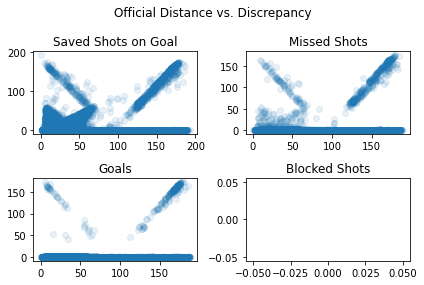

In [24]:
fig, axs = plt.subplots(2,2);
axs[0,0].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event=='SHOT'], label=event_type, alpha=0.1);
axs[0,0].set_title('Saved Shots on Goal');
axs[0,1].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event=='MISS'], label=event_type, alpha=0.1);
axs[0,1].set_title('Missed Shots');
axs[1,0].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event=='GOAL'], label=event_type, alpha=0.1);
axs[1,0].set_title('Goals');
axs[1,1].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event=='BLOCK'], label=event_type, alpha=0.1);
axs[1,1].set_title('Blocked Shots');
plt.suptitle('Official Distance vs. Discrepancy');
fig.tight_layout()

There seems to be a systematic difference that can be seen in saves and missed shots that is separate from the mis-coding for attacking ends.

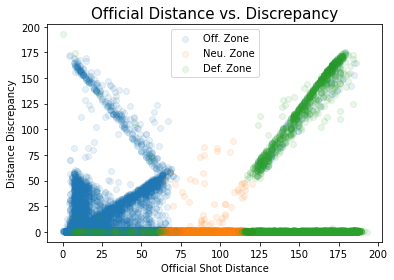

In [25]:
event_zones = shot_frame.event_zone.unique()
for zone in event_zones:
    plt.scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event_zone==zone], label=zone, alpha=0.1);
plt.xlabel('Official Shot Distance');
plt.ylabel('Distance Discrepancy');
plt.title('Official Distance vs. Discrepancy', fontsize=15);
plt.legend();

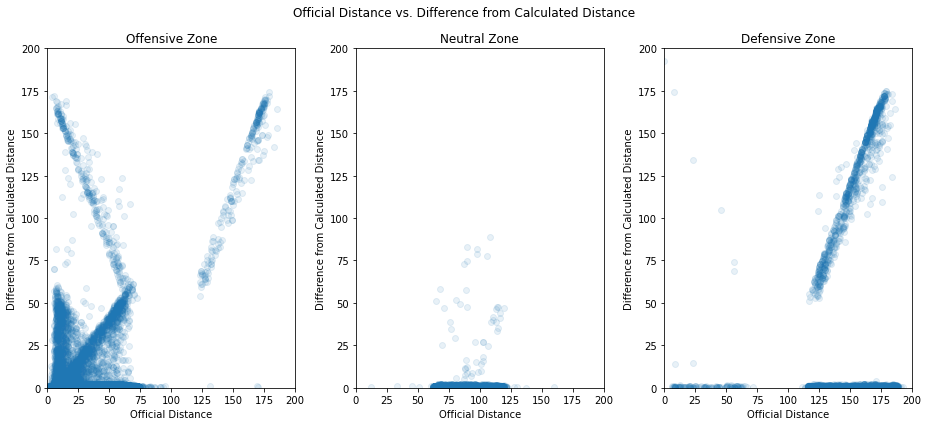

In [26]:
fig, axs = plt.subplots(1,3,figsize=(13,6));
for i in range(3):
    axs[i].set_xlabel('Official Distance');
    axs[i].set_ylabel('Difference from Calculated Distance');
    axs[i].set_xlim(0,200);
    axs[i].set_ylim(0,200);
axs[0].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event_zone=='Off. Zone'], label=zone, alpha=0.1);
axs[0].set_title('Offensive Zone');
axs[1].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event_zone=='Neu. Zone'], label=zone, alpha=0.1);
axs[1].set_title('Neutral Zone');
axs[2].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event_zone=='Def. Zone'], label=zone, alpha=0.1);
axs[2].set_title('Defensive Zone');
plt.suptitle('Official Distance vs. Difference from Calculated Distance');

fig.tight_layout()

No shots less than 60 feet from the goal can be correctly coded as defensive zone. There are a number of shots where coordinates and distance agree where the zone is obviously-miscoded. This will be handled later.

There are two other patterns seen in the shots. The first is a line with slope near 1 in the offensive zone plot. The other is a near vertical-line associated with very short distance shots.

The offensive zone is the set of coordinates with $x$-coordinate of at least 25. The $y$-coordinate can vary between -42.5 and 42.5. Since the center of the goal is located at $(89,0)$, the longest possible shot in the offensive zone has length $\sqrt{(89-25)^2 + (42.5)^2} \approx 77$

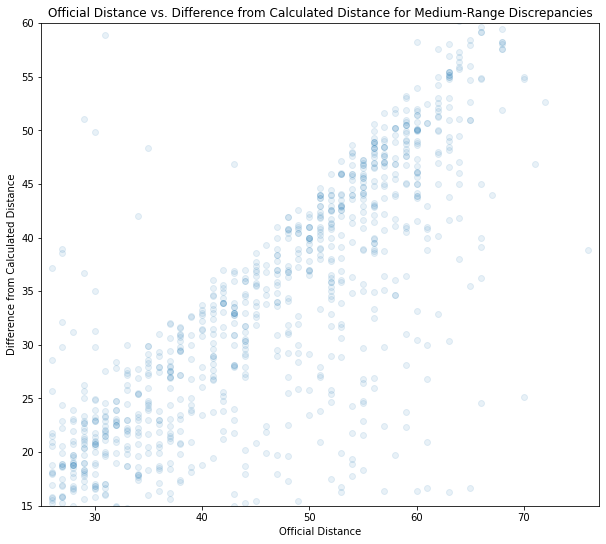

In [27]:
fig = plt.figure(figsize=(10,60))
plt.gca().set_aspect(aspect='equal')
plt.xlim(25,77);
plt.ylim(15,60);
plt.scatter(x='shot_dist', y='dist_difference', data=shot_frame[(shot_frame.shot_dist > 25) 
                                                                & (shot_frame.shot_dist < 77) 
                                                                & (shot_frame.dist_difference > 10)], alpha=0.1);
plt.title('Official Distance vs. Difference from Calculated Distance for Medium-Range Discrepancies');
plt.xlabel('Official Distance');
plt.ylabel('Difference from Calculated Distance');

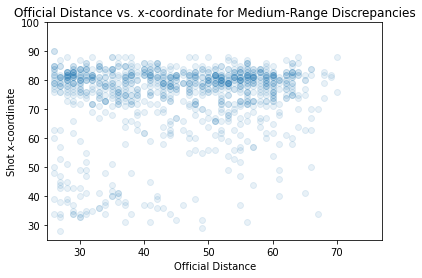

In [28]:
plt.xlim(25,77);
plt.ylim(25,100);
plt.scatter(x='shot_dist', y='event_coord_x', data=shot_frame[(shot_frame.shot_dist > 25) 
                                                              & (shot_frame.shot_dist < 77) 
                                                              & (shot_frame.dist_difference > 10)], alpha=0.1);
plt.xlabel('Official Distance');
plt.ylabel('Shot x-coordinate');
plt.title('Official Distance vs. x-coordinate for Medium-Range Discrepancies');

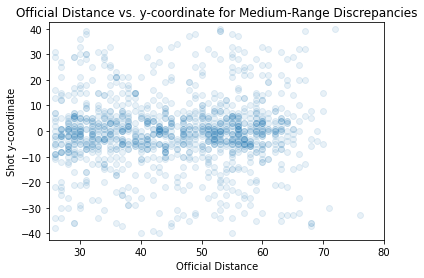

In [29]:
plt.xlim(25,80);
plt.ylim(-42.5, 42.5);
plt.scatter(x='shot_dist', y='event_coord_y', data=shot_frame[(shot_frame.shot_dist > 25) 
                                                              & (shot_frame.shot_dist < 77) 
                                                              & (shot_frame.dist_difference > 10)], alpha=0.1);
plt.xlabel('Official Distance');
plt.ylabel('Shot y-coordinate');
plt.title('Official Distance vs. y-coordinate for Medium-Range Discrepancies');

Interestingly enough, most of the shots considered here seem to have coordinates near $x=80$ and $y=0$. This is just in front of the goal, which suggests that these might be shots which were found after-the-fact to have been deflected into the goal. This is a non-uncommon determination in the NHL, which results in an adjustment to the shooting player in the statistics.

In [30]:
shot_frame[(shot_frame.shot_dist > 25) 
           & (shot_frame.shot_dist < 77) 
           & (shot_frame.dist_difference > 10)]['shot_type'].value_counts(normalize=True)

Wrist        0.495287
Slap         0.329049
Snap         0.138817
Backhand     0.027421
Tip-In       0.006855
Deflected    0.002571
Name: shot_type, dtype: float64

In [31]:
shot_frame[(shot_frame.shot_dist > 25) 
           & (shot_frame.shot_dist < 77) 
           & (shot_frame.dist_difference > 10)]['secondary_type'].value_counts(normalize=True)

Wrist Shot     0.552682
Backhand       0.161877
Slap Shot      0.110153
Snap Shot      0.098659
Tip-In         0.057471
Deflected      0.013410
Wrap-around    0.005747
Name: secondary_type, dtype: float64

The category `secondary_type` is taken from the live feed, which is the data source which can be adjusted later. The category `shot_type` is extracted from the play-by-play. Notice that there are far more shots categorized as `Tip-In` or `Deflected` in the `secondary_type` column and far fewer `Slap` (`Slap Shot`) values. This suggests that this variation arises from post-game adjustment to the shot location. Additionally, this would suggest that the event-coordinates for these shots should be preferred.

Now, conduct a similar analysis for shots indicated at extremely short-range.

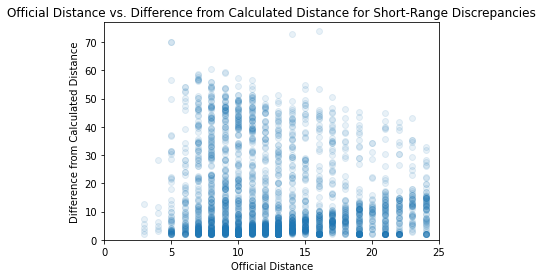

In [32]:
plt.xlim(0,25);
plt.ylim(0,77);
plt.scatter(x='shot_dist', y='dist_difference', data=shot_frame[(shot_frame.shot_dist < 25)
                                                                & (shot_frame.dist_difference >= 2)],alpha=0.1);
plt.title('Official Distance vs. Difference from Calculated Distance for Short-Range Discrepancies');
plt.xlabel('Official Distance');
plt.ylabel('Difference from Calculated Distance');

Toward the bottom of this plot, it is possible to see the overlap with the preceding analysis. Consequently, the data will be replotted to exclude shots where the coordinates report short distances.

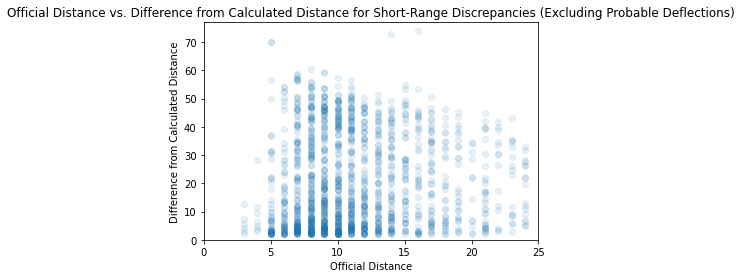

In [33]:
plt.xlim(0,25);
plt.ylim(0,77);
plt.scatter(x='shot_dist', y='dist_difference', data=shot_frame[(shot_frame.shot_dist < 25)
                                                                & (shot_frame.dist_difference >= 2)
                                                                & (shot_frame.calc_dist > shot_frame.shot_dist)],alpha=0.1);
plt.title('Official Distance vs. Difference from Calculated Distance for Short-Range Discrepancies (Excluding Probable Deflections)');
plt.xlabel('Official Distance');
plt.ylabel('Difference from Calculated Distance');

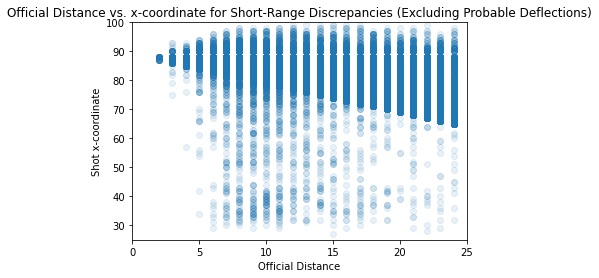

In [34]:
plt.xlim(0,25);
plt.ylim(25,100);
plt.scatter(x='shot_dist', y='event_coord_x', data=shot_frame[(shot_frame.shot_dist < 25) 
                                                              & (shot_frame.shot_dist >= 2) 
                                                              & (shot_frame.calc_dist > shot_frame.shot_dist)], alpha=0.1);
plt.xlabel('Official Distance');
plt.ylabel('Shot x-coordinate');
plt.title('Official Distance vs. x-coordinate for Short-Range Discrepancies (Excluding Probable Deflections)');

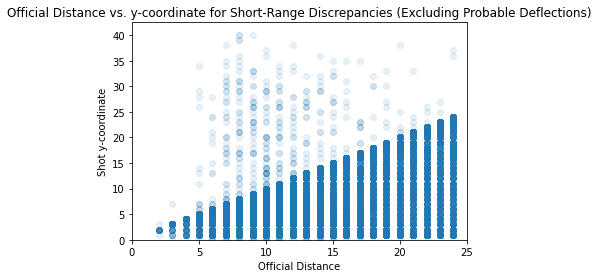

In [35]:
plt.xlim(0,25);
plt.ylim(0,42.5);
plt.scatter(x='shot_dist', y='event_coord_y', data=shot_frame[(shot_frame.shot_dist < 25) 
                                                              & (shot_frame.shot_dist >= 2) 
                                                              & (shot_frame.calc_dist > shot_frame.shot_dist)], alpha=0.1);
plt.xlabel('Official Distance');
plt.ylabel('Shot y-coordinate');
plt.title('Official Distance vs. y-coordinate for Short-Range Discrepancies (Excluding Probable Deflections)');

In [36]:
shot_frame[(shot_frame.shot_dist < 25) 
           & (shot_frame.shot_dist >= 2) 
           & (shot_frame.calc_dist > shot_frame.shot_dist)]['shot_type'].value_counts(normalize=True)

Wrist          0.512634
Backhand       0.184913
Snap           0.096814
Tip-In         0.094252
Wrap-around    0.053265
Deflected      0.033201
Slap           0.024921
Name: shot_type, dtype: float64

In [37]:
shot_frame[(shot_frame.shot_dist < 25) 
           & (shot_frame.shot_dist >= 2) 
           & (shot_frame.calc_dist > shot_frame.shot_dist)]['secondary_type'].value_counts(normalize=True)

Wrist Shot     0.533166
Backhand       0.184117
Snap Shot      0.102460
Tip-In         0.070871
Wrap-around    0.058325
Slap Shot      0.027480
Deflected      0.023580
Name: secondary_type, dtype: float64

While the trend isn't as prevalent as in the preceding analysis, there does appear to be a slight recategorization of shots away from deflected shots (`Tip-In` and `Deflected`). This may also indicate the result of post-game recoding of shots. Consequently, the coordinates will be used unchanged here.

Zone-miscoding still must be handled. Defensive zone shots are rare due to the length and the low-probability of scoring a goal. The working presumption should be that if the distances disagree, this is likely a consequence of a mis-coding which had one of the sources incorrectly mark the shot as coming from the defensive zone. This leads to the following.
1. Shots coded as the offensive zone: This zone coding is presumptively correct. Any coordinates which appear to place the shot outside of the offensive zone should be rotated to conform to this.
2. Shots coded as the neutral zone: There doesn't appear to be any common bias with these shots. Particularly there is no strong presumption for correctness of one set of data, so these shots will be left unchanged.
3. Shots coded as the defensive zone: This zone coding is presumptively incorrect. There is a considerable minority of shots which distance and coordinates seem to indicate actually took place in the offensive zone. These coordinates will be accepted as correct. For official shot distances which agree with being taken from the defensive zone, the coordinates will take precedence. This means that if the coordinates appear to indicate a shot from the offensive zone, these will be used instead.

The only listed category that requires adjustment to the coordinates are shots coded as offensive zone shots.

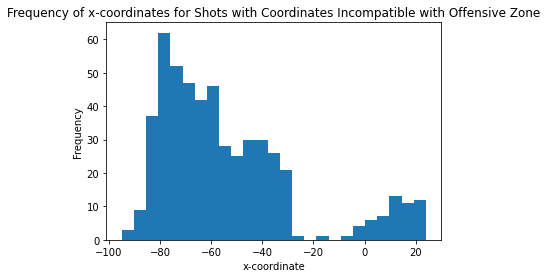

In [38]:
plt.hist(x='event_coord_x',data=shot_frame[(shot_frame.event_zone=='Off. Zone') & (shot_frame.event_coord_x < 25)], bins=25);
plt.xlabel('x-coordinate');
plt.ylabel('Frequency');
plt.title('Frequency of x-coordinates for Shots with Coordinates Incompatible with Offensive Zone');

The histogram seems to indicate that there are two sources of mis-categorization of these shots. First, the sizable majority of shots have $x$-coordinate less than $-25$. These shots would seem to be coming from the defensive zone. These are likely incorrect, and should be adjusted. The second is a number of shots which are mostly coming from positive $x$-coordinates. These shots are largely recorded as coming from the attacking half of the neutral zone. These are more likely to be miscoded in terms of the event zone. These coordinates will be left unchanged. Only offensive zone shots with $x \leq -25$ will be adjusted.

In [39]:
adjusted_x = np.where((shot_frame.event_zone=='Off. Zone') & (shot_frame.event_coord_x < -25), 
                      -shot_frame.event_coord_x,
                      shot_frame.event_coord_x)
adjusted_y = np.where((shot_frame.event_zone=='Off. Zone') & (shot_frame.event_coord_x < -25), 
                      -shot_frame.event_coord_y,
                      shot_frame.event_coord_y)
shot_frame['event_coord_x'] = adjusted_x
shot_frame['event_coord_y'] = adjusted_y

All other differences from zones to coordinates were presumed to be a mis-coding of the zone. Correct that now.

In [40]:
shot_frame['event_zone'].unique()

array(['Off. Zone', 'Neu. Zone', 'Def. Zone'], dtype=object)

In [41]:
def correct_zone(x):
    if (x <= -25):
        return 'Def. Zone'
    elif (x >= 25):
        return 'Off. Zone'
    else:
        return 'Neu. Zone'
shot_frame['event_zone'] = shot_frame.event_coord_x.apply(lambda x: correct_zone(x))

Since some coordinates were adjusted, the calculated distances (and angles) need to be re-calculated.

In [42]:
shot_frame['calc_dist'] = np.sqrt((shot_frame['event_coord_x']-89)**2 + shot_frame['event_coord_y']**2)
shot_frame['dist_difference'] = np.abs(shot_frame['calc_dist'] - shot_frame['shot_dist'])
shot_frame['calc_angle'] = np.arctan2(shot_frame['event_coord_y'], 89 - shot_frame['event_coord_x']) * 180 / np.pi

Re-examine the earlier analysis with these adjustments.

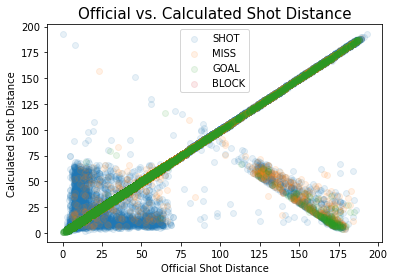

In [43]:
event_types = shot_frame.event.unique()
for event_type in event_types:
    plt.scatter(x='shot_dist', y='calc_dist', data=shot_frame[shot_frame.event==event_type], label=event_type, alpha=0.1);
plt.xlabel('Official Shot Distance');
plt.ylabel('Calculated Shot Distance');
plt.title('Official vs. Calculated Shot Distance', fontsize=15);
plt.legend();

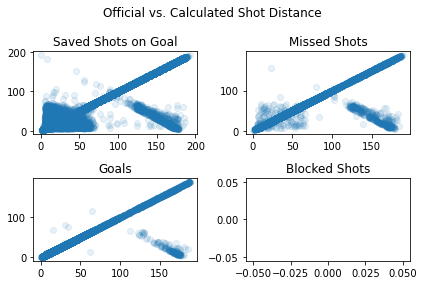

In [44]:
fig, axs = plt.subplots(2,2);
axs[0,0].scatter(x='shot_dist', y='calc_dist', data=shot_frame[shot_frame.event=='SHOT'], label=event_type, alpha=0.1);
axs[0,0].set_title('Saved Shots on Goal');
axs[0,1].scatter(x='shot_dist', y='calc_dist', data=shot_frame[shot_frame.event=='MISS'], label=event_type, alpha=0.1);
axs[0,1].set_title('Missed Shots');
axs[1,0].scatter(x='shot_dist', y='calc_dist', data=shot_frame[shot_frame.event=='GOAL'], label=event_type, alpha=0.1);
axs[1,0].set_title('Goals');
axs[1,1].scatter(x='shot_dist', y='calc_dist', data=shot_frame[shot_frame.event=='BLOCK'], label=event_type, alpha=0.1);
axs[1,1].set_title('Blocked Shots');
plt.suptitle('Official vs. Calculated Shot Distance');
fig.tight_layout()

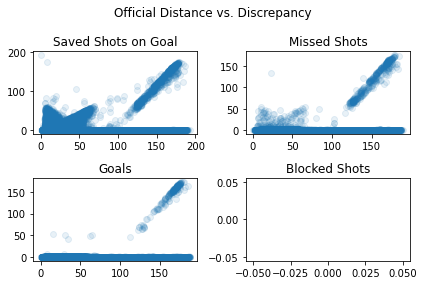

In [45]:
fig, axs = plt.subplots(2,2);
axs[0,0].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event=='SHOT'], label=event_type, alpha=0.1);
axs[0,0].set_title('Saved Shots on Goal');
axs[0,1].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event=='MISS'], label=event_type, alpha=0.1);
axs[0,1].set_title('Missed Shots');
axs[1,0].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event=='GOAL'], label=event_type, alpha=0.1);
axs[1,0].set_title('Goals');
axs[1,1].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event=='BLOCK'], label=event_type, alpha=0.1);
axs[1,1].set_title('Blocked Shots');
plt.suptitle('Official Distance vs. Discrepancy');
fig.tight_layout()

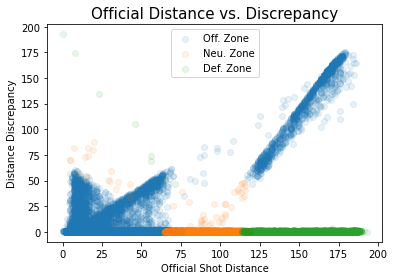

In [46]:
event_zones = shot_frame.event_zone.unique()
for zone in event_zones:
    plt.scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event_zone==zone], label=zone, alpha=0.1);
plt.xlabel('Official Shot Distance');
plt.ylabel('Distance Discrepancy');
plt.title('Official Distance vs. Discrepancy', fontsize=15);
plt.legend();

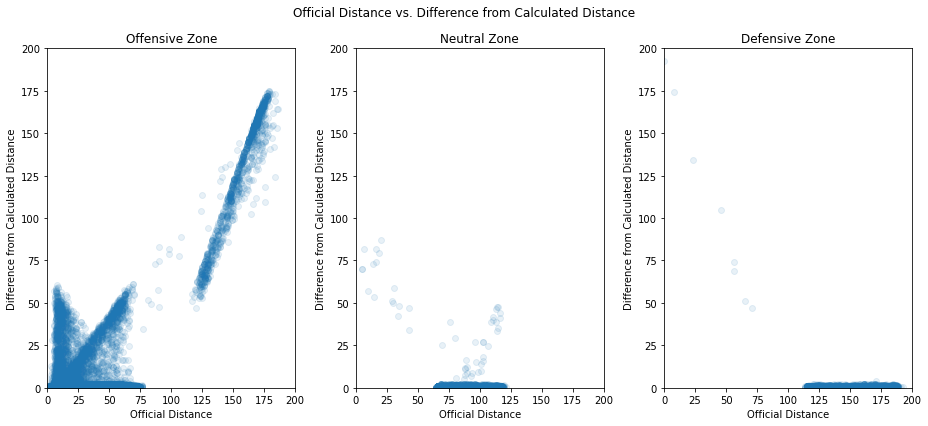

In [47]:
fig, axs = plt.subplots(1,3,figsize=(13,6));
for i in range(3):
    axs[i].set_xlabel('Official Distance');
    axs[i].set_ylabel('Difference from Calculated Distance');
    axs[i].set_xlim(0,200);
    axs[i].set_ylim(0,200);
axs[0].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event_zone=='Off. Zone'], label=zone, alpha=0.1);
axs[0].set_title('Offensive Zone');
axs[1].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event_zone=='Neu. Zone'], label=zone, alpha=0.1);
axs[1].set_title('Neutral Zone');
axs[2].scatter(x='shot_dist', y='dist_difference', data=shot_frame[shot_frame.event_zone=='Def. Zone'], label=zone, alpha=0.1);
axs[2].set_title('Defensive Zone');
plt.suptitle('Official Distance vs. Difference from Calculated Distance');

fig.tight_layout()

The anomolies which were called out for correction seem to have disappeared. At this point, the `calc_dist` field is likely to be more accurate, so will be the only distance field retained. Likewise, `dist_difference` is no longer required

In [48]:
shot_frame.drop(['shot_dist', 'dist_difference'], axis=1, inplace=True)

In [49]:
shot_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428115 entries, 0 to 1428367
Data columns (total 33 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   game_id_livefeed    1428115 non-null  object 
 1   season              1428115 non-null  object 
 2   type                1428115 non-null  object 
 3   game_time           1428115 non-null  object 
 4   venue               1428115 non-null  object 
 5   period              1428115 non-null  int64  
 6   period_ord          1428115 non-null  object 
 7   period_type         1428115 non-null  object 
 8   time_elapsed        1428115 non-null  object 
 9   cum_time_elapsed    1428115 non-null  float64
 10  event               1428115 non-null  object 
 11  event_team_code     1428115 non-null  object 
 12  event_team_is_home  1428115 non-null  bool   
 13  event_coord_x       1428115 non-null  float64
 14  event_coord_y       1428115 non-null  float64
 15  secondary_type 

The preceding analysis also provided reasons to believe that, while `secondary_type` and `shot_type` both provide shot-type information, `secondary_type` is likely to be more accurate when it is provided.

In [50]:
shot_types = np.where(shot_frame.secondary_type.isna(), shot_frame.shot_type, shot_frame.secondary_type)
shot_frame['shot_type'] = shot_types

In [51]:
shot_frame.drop(['secondary_type'], axis=1, inplace=True)

In [52]:
shot_frame['shot_type'].unique()

array(['Snap Shot', 'Wrist', 'Wrist Shot', 'Snap', 'Slap Shot', 'Slap',
       'Backhand', 'Tip-In', 'Deflected', 'Wrap-around', None],
      dtype=object)

This introduced some mess, as any type suffixed by `Shot` is the same as that type without the suffix.

In [53]:
shot_types = {
    'Snap Shot': 'Snap',
    'Wrist Shot': 'Wrist',
    'Slap Shot': 'Slap'
}
shot_frame['shot_type'].replace(shot_types, inplace=True)

In [54]:
shot_frame['shot_type'].unique()

array(['Snap', 'Wrist', 'Slap', 'Backhand', 'Tip-In', 'Deflected',
       'Wrap-around', None], dtype=object)

In [55]:
shot_frame['shot_type'].value_counts()

Wrist          740595
Slap           299429
Snap           194593
Backhand        91388
Tip-In          66286
Deflected       24069
Wrap-around     11675
Name: shot_type, dtype: int64

In [56]:
shot_frame['shot_type'].describe()

count     1428035
unique          7
top         Wrist
freq       740595
Name: shot_type, dtype: object

In [57]:
shot_frame[shot_frame['shot_type'].isna()]

,game_id_livefeed,season,type,game_time,venue,period,period_ord,period_type,time_elapsed,cum_time_elapsed,event,event_team_code,event_team_is_home,event_coord_x,event_coord_y,is_rebound,time_remaining,seconds_remaining,event_zone,miss_type,shot_type,calc_dist,calc_angle,players_shooting,skaters_shooting,fwds_shooting,attacker_state,is_extra_attacker,is_empty_net,players_defending,skaters_defending,fwds_defending
21144,2010020193,20102011,R,2010-11-06T23:00:00Z,Philips Arena,4,OT,OVERTIME,04:21,3861.0,SHOT,CHI,False,61.0,-8.0,False,00:39,39.0,Off. Zone,Save,None,29.120440,-15.945396,5,4,2,4-on-4,False,False,5,4,3
112177,2010021015,20102011,R,2011-03-12T00:00:00Z,Nassau Coliseum,3,3rd,REGULAR,15:44,3344.0,SHOT,BOS,False,81.0,-7.0,True,04:16,256.0,Off. Zone,Save,None,10.630146,-41.185925,6,5,2,5-on-5,False,False,6,5,3
112183,2010021015,20102011,R,2011-03-12T00:00:00Z,Nassau Coliseum,3,3rd,REGULAR,19:50,3590.0,GOAL,NYI,True,38.0,-36.0,False,00:10,10.0,Off. Zone,Goal,None,62.425956,-35.217593,6,5,3,5-on-6,False,True,6,6,4
113353,2010021026,20102011,R,2011-03-13T00:00:00Z,Wells Fargo Center,3,3rd,REGULAR,01:00,2460.0,BLOCK,PHI,True,68.0,-0.0,False,19:00,1140.0,Off. Zone,Block,None,21.000000,-0.000000,6,5,3,5-on-5,False,False,6,5,3
139436,2010030174,20102011,P,2011-04-21T02:30:00Z,Jobing.com Arena,3,3rd,REGULAR,19:24,3564.0,GOAL,DET,False,77.0,-0.0,False,00:36,36.0,Off. Zone,Goal,None,12.000000,-0.000000,6,5,3,5-on-6,False,True,6,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377323,2019020776,20192020,R,2020-01-30T00:30:00Z,Capital One Arena,2,2nd,REGULAR,06:01,1561.0,GOAL,WSH,True,26.0,-40.0,False,13:59,839.0,Off. Zone,Goal,None,74.625733,-32.412307,6,5,3,5-on-5,False,False,6,5,3
1381192,2019020809,20192020,R,2020-02-04T00:00:00Z,Scotiabank Arena,3,3rd,REGULAR,19:12,3552.0,GOAL,FLA,False,69.0,0.0,False,00:48,48.0,Off. Zone,Goal,None,20.000000,0.000000,6,5,2,5-on-6,False,True,6,6,5
1388500,2019020873,20192020,R,2020-02-12T01:30:00Z,American Airlines Center,3,3rd,REGULAR,18:41,3521.0,GOAL,DAL,True,65.0,14.0,False,01:19,79.0,Off. Zone,Goal,None,27.784888,30.256437,6,5,3,5-on-6,False,True,6,6,4
1417531,2019030016,20192020,R,2020-08-09T19:00:00Z,Rogers Place,4,OT,OVERTIME,02:24,3744.0,SHOT,DAL,False,77.0,-9.0,False,02:36,156.0,Off. Zone,Save,None,15.000000,-36.869898,4,3,2,3-on-3,False,False,4,3,2


There are only a handful of missing shot-types. Dropping those shouldn't be a concern.

In [58]:
shot_frame.dropna(subset=['shot_type'], inplace=True)

In [59]:
shot_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428035 entries, 0 to 1428367
Data columns (total 32 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   game_id_livefeed    1428035 non-null  object 
 1   season              1428035 non-null  object 
 2   type                1428035 non-null  object 
 3   game_time           1428035 non-null  object 
 4   venue               1428035 non-null  object 
 5   period              1428035 non-null  int64  
 6   period_ord          1428035 non-null  object 
 7   period_type         1428035 non-null  object 
 8   time_elapsed        1428035 non-null  object 
 9   cum_time_elapsed    1428035 non-null  float64
 10  event               1428035 non-null  object 
 11  event_team_code     1428035 non-null  object 
 12  event_team_is_home  1428035 non-null  bool   
 13  event_coord_x       1428035 non-null  float64
 14  event_coord_y       1428035 non-null  float64
 15  is_rebound     

There appears to be no remaining null data.

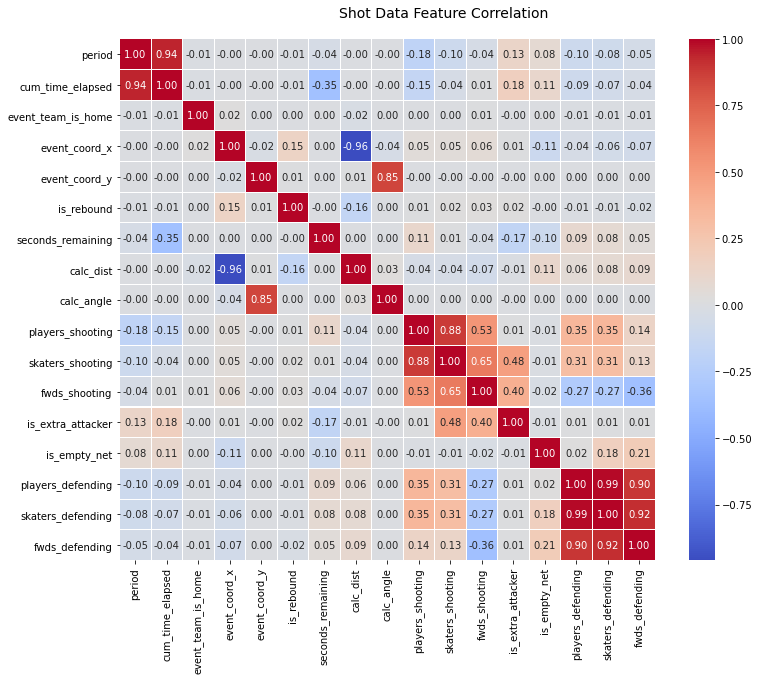

In [60]:
corrmat = shot_frame.corr();
fig, ax = plt.subplots(figsize=(12, 9));
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05);
fig.subplots_adjust(top=0.93);
fig.suptitle('Shot Data Feature Correlation', fontsize=14);

There is nothing here that couldn't have been anticipated from knowledge of how fields are defined and the rules of the game. For example, periods are 20 minutes in length, so the high correlation between `period` and `cum_time_elapsed` is expected. The more interesting observations will be hidden in the categorical variables, so these will be one-hot encoded.

In [61]:
shot_frame['is_goal'] = (shot_frame['event'] == 'GOAL')

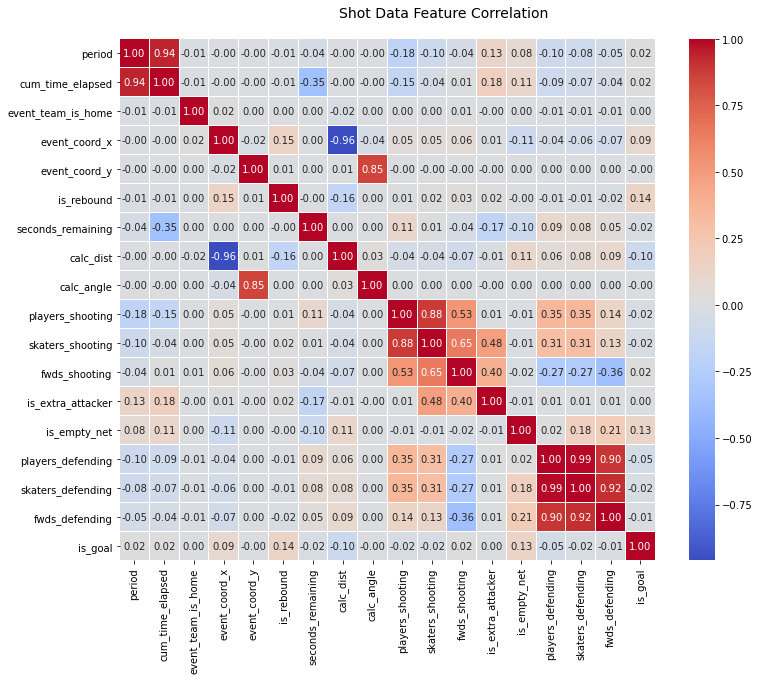

In [62]:
corrmat = shot_frame.corr();
fig, ax = plt.subplots(figsize=(12, 9));
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05);
fig.subplots_adjust(top=0.93);
fig.suptitle('Shot Data Feature Correlation', fontsize=14);

Encoding `is_goal` as a boolean does show that there seems to be a connection between rebounds and goals. Unsurprisingly, there is also a correlation between goals and empty nets. More of a surprise is the lack of any correlation between extra attackers and goals at this level. 

In [63]:
# shot_frame_coded = pd.get_dummies(shot_frame, columns=['type', 'period_type', 'event', 'event_zone', 'miss_type', 'shot_type', 'attacker_state'], sparse=True)

In [64]:
# corrmat = shot_frame_coded.corr();
# fig, ax = plt.subplots(figsize=(24, 18));
# sns.heatmap(round(corrmat,2), ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05);
# #fig.subplots_adjust(top=0.93);
# fig.suptitle('Shot Data Feature Correlation', fontsize=14);

This provides little additional information, but there are additional visualizations that should provide value.

In [65]:
img = mpimg.imread('NHL_Hockey_Rink.png')

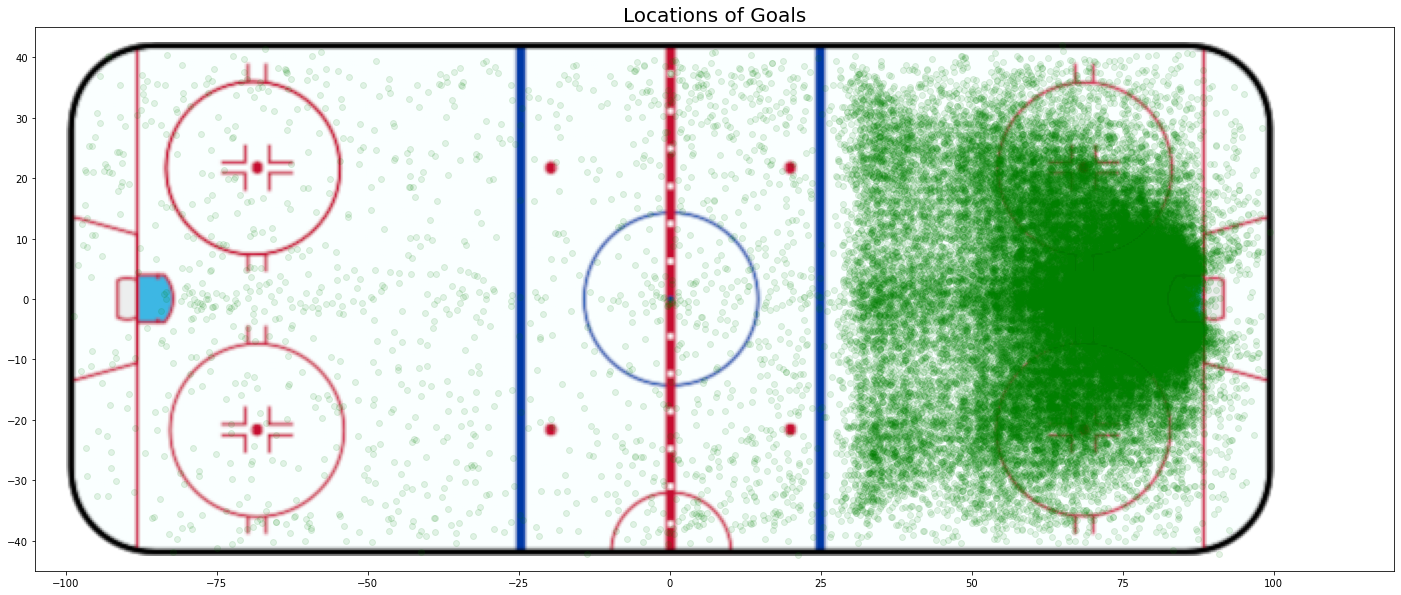

In [66]:
fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,120))
ax.set_ylim((-45,45))
plt.imshow(img, origin='lower', extent=(-100,100,-42.5,42.5));

plt.scatter(x=np.where(shot_frame['is_goal']==True,shot_frame['event_coord_x'],None), 
            y=np.where(shot_frame['is_goal']==True,shot_frame['event_coord_y'],None), 
            c='green', alpha=0.1, label='goal');

dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.5, 0.5, offsets.shape)
dots.set_offsets(jittered_offsets)

plt.title('Locations of Goals', fontsize=20);

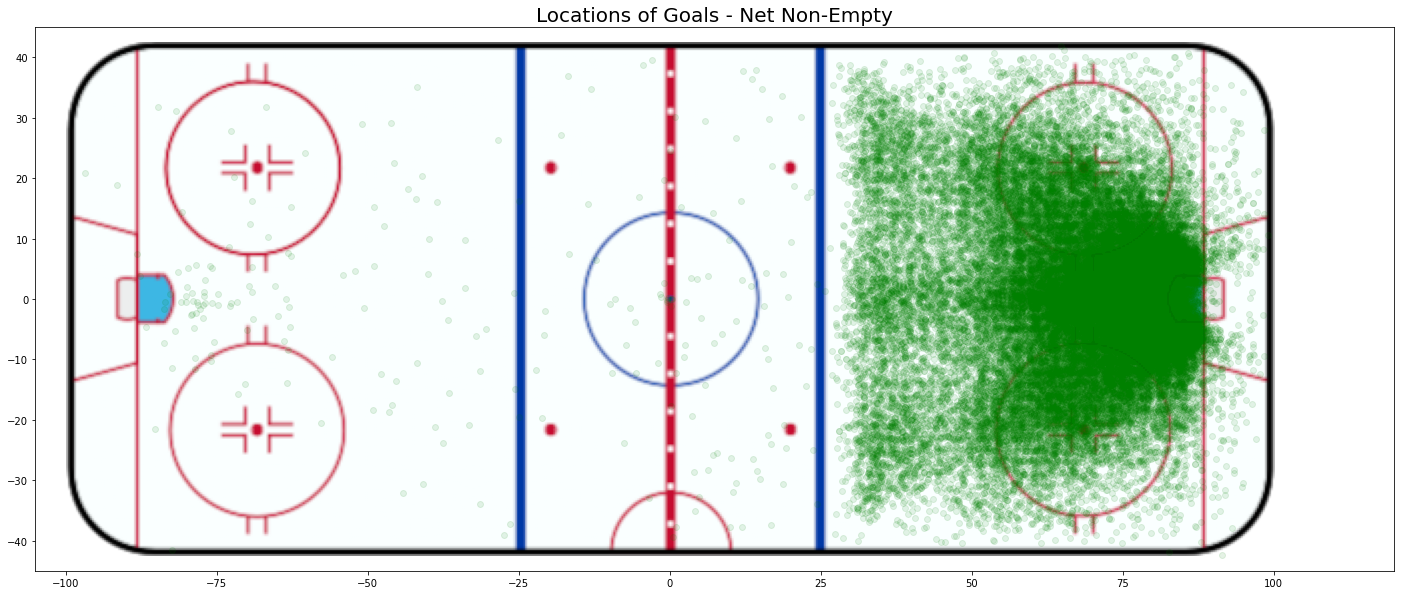

In [67]:
fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,120))
ax.set_ylim((-45,45))
plt.imshow(img, origin='lower', extent=(-100,100,-42.5,42.5));

plt.scatter(x=np.where((shot_frame['is_goal']==True)&(shot_frame['is_empty_net']==False),shot_frame['event_coord_x'],None), 
            y=np.where((shot_frame['is_goal']==True)&(shot_frame['is_empty_net']==False),shot_frame['event_coord_y'],None), 
            c='green', alpha=0.1, label='goal');

dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.5, 0.5, offsets.shape)
dots.set_offsets(jittered_offsets)

plt.title('Locations of Goals - Net Non-Empty', fontsize=20);

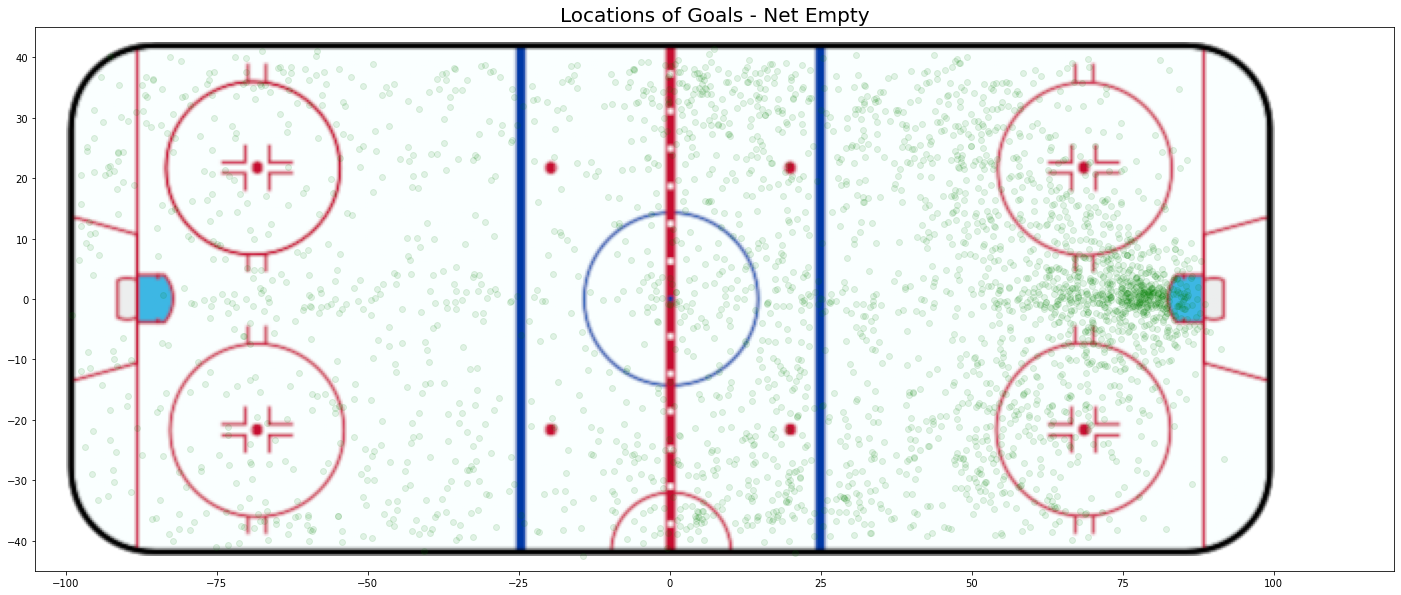

In [68]:
fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,120))
ax.set_ylim((-45,45))
plt.imshow(img, origin='lower', extent=(-100,100,-42.5,42.5));

plt.scatter(x=np.where((shot_frame['is_goal']==True)&(shot_frame['is_empty_net']==True),shot_frame['event_coord_x'],None), 
            y=np.where((shot_frame['is_goal']==True)&(shot_frame['is_empty_net']==True),shot_frame['event_coord_y'],None), 
            c='green', alpha=0.1, label='goal');

dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.5, 0.5, offsets.shape)
dots.set_offsets(jittered_offsets)

plt.title('Locations of Goals - Net Empty', fontsize=20);

In [69]:
pd.pivot_table(shot_frame, index='attacker_state', values='is_goal', aggfunc="mean")

,is_goal
attacker_state,
3-on-3,0.096237
3-on-4,0.051724
3-on-5,0.056338
3-on-6,0.000000
4-on-3,0.089039
4-on-4,0.050733
4-on-5,0.061367
4-on-6,0.439430
5-on-3,0.120626


In [70]:
pd.pivot_table(shot_frame[shot_frame['is_empty_net']==False], index='attacker_state', values='is_goal', aggfunc="mean")

,is_goal
attacker_state,
3-on-3,0.096237
3-on-4,0.051724
3-on-5,0.050000
4-on-3,0.089039
4-on-4,0.050635
4-on-5,0.060049
5-on-3,0.120626
5-on-4,0.066055
5-on-5,0.041360


Unsuprisingly, the probability of scoring a goal increases as attackers outnumber defenders.

In [71]:
pd.pivot_table(shot_frame, index='attacker_state', columns='period', values='is_goal', aggfunc="mean")

period,1,2,3,4,5,6,7,8
attacker_state,,,,,,,,
3-on-3,0.000000,0.500000,0.083333,0.096088,NaN,NaN,NaN,NaN
3-on-4,0.066667,0.000000,0.125000,0.046296,NaN,NaN,NaN,NaN
3-on-5,0.045455,0.052632,0.073171,NaN,NaN,NaN,NaN,NaN
3-on-6,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
4-on-3,0.079470,0.071320,0.095495,0.094079,NaN,NaN,NaN,NaN
4-on-4,0.040991,0.056601,0.055007,0.048921,NaN,NaN,NaN,NaN
4-on-5,0.056687,0.062907,0.064071,0.026316,0.166667,NaN,NaN,NaN
4-on-6,0.000000,0.333333,0.442308,NaN,NaN,NaN,NaN,NaN
5-on-3,0.125061,0.119959,0.117929,0.047619,NaN,NaN,NaN,NaN


In [72]:
pd.pivot_table(shot_frame, index='attacker_state', columns='period', values='is_goal', aggfunc="count")

period,1,2,3,4,5,6,7,8
attacker_state,,,,,,,,
3-on-3,3.0,4.0,12.0,7847.0,NaN,NaN,NaN,NaN
3-on-4,15.0,27.0,24.0,108.0,NaN,NaN,NaN,NaN
3-on-5,44.0,57.0,41.0,NaN,NaN,NaN,NaN,NaN
3-on-6,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
4-on-3,453.0,659.0,555.0,2466.0,NaN,NaN,NaN,NaN
4-on-4,5245.0,7332.0,6072.0,9873.0,NaN,NaN,NaN,NaN
4-on-5,8591.0,11684.0,8475.0,38.0,6.0,NaN,NaN,NaN
4-on-6,2.0,3.0,416.0,NaN,NaN,NaN,NaN,NaN
5-on-3,2055.0,2926.0,2086.0,21.0,NaN,NaN,NaN,NaN


In [73]:
pd.pivot_table(shot_frame, index='attacker_state', columns='period', values='is_goal', aggfunc="sum")

period,1,2,3,4,5,6,7,8
attacker_state,,,,,,,,
3-on-3,0.0,2.0,1.0,754.0,NaN,NaN,NaN,NaN
3-on-4,1.0,0.0,3.0,5.0,NaN,NaN,NaN,NaN
3-on-5,2.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN
3-on-6,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4-on-3,36.0,47.0,53.0,232.0,NaN,NaN,NaN,NaN
4-on-4,215.0,415.0,334.0,483.0,NaN,NaN,NaN,NaN
4-on-5,487.0,735.0,543.0,1.0,1.0,NaN,NaN,NaN
4-on-6,0.0,1.0,184.0,NaN,NaN,NaN,NaN,NaN
5-on-3,257.0,351.0,246.0,1.0,NaN,NaN,NaN,NaN


Most of the larger probabilities by period are a function of the event rarely happening. It does seem intriguing that 5-on-5 goals seem to be more common in the second period than in the first.

In [74]:
count = np.array([14794, 16748])
nobs = np.array([379780, 381500])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))

0.000


In [75]:
count = np.array([16748, 14556])
nobs = np.array([381500, 350012])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))

0.000


It seems that the difference between periods is statistically significant. This is something that could be investigated further. There are rule-based reasons why second-period goals may be more likely. In particular, the teams change sides between periods. In the second period, goaltenders are further from their team's bench than in the first period. This makes it more difficult to make substitutions without allowing a scoring chance.

In [76]:
pd.pivot_table(shot_frame, index='event_team_is_home', values='is_goal', aggfunc="mean")

,is_goal
event_team_is_home,
False,0.047407
True,0.049415


In [77]:
pd.pivot_table(shot_frame, index='is_rebound', values='is_goal', aggfunc="mean")

,is_goal
is_rebound,
False,0.040947
True,0.163766


In [78]:
pd.pivot_table(shot_frame, index='shot_type', values='is_goal', aggfunc="mean")

,is_goal
shot_type,
Backhand,0.073467
Deflected,0.091487
Slap,0.027599
Snap,0.052325
Tip-In,0.099885
Wrap-around,0.046938
Wrist,0.046773


There seems to be a relationship between shot-selection and goals.

In [79]:
dist_probs = pd.pivot_table(shot_frame[shot_frame['is_empty_net']==False], index='calc_dist', values='is_goal', aggfunc=('count','sum','mean')).reset_index()

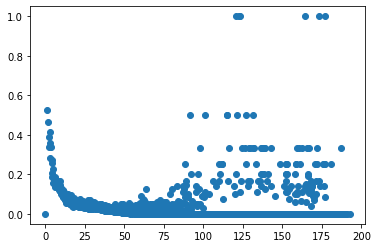

In [80]:
plt.scatter(x='calc_dist', y='mean', data=dist_probs);

There seems to be a near-exponential decline in likelihood of scoring goals as shots are taken further from the net.

In [81]:
angle_probs = pd.pivot_table(shot_frame[shot_frame['is_empty_net']==False], index='calc_angle', values='is_goal', aggfunc=('count','sum','mean')).reset_index()

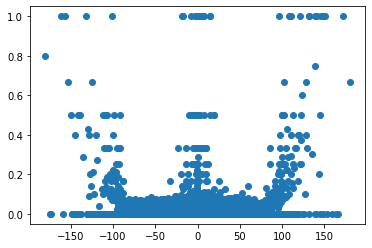

In [82]:
plt.scatter(x='calc_angle', y='mean', data=angle_probs);

The relationship between angle and goal-scoring will require more examination.

In [83]:
pd.pivot_table(shot_frame[shot_frame['is_empty_net']==False], index='fwds_shooting', values='is_goal', aggfunc="mean")

,is_goal
fwds_shooting,
1,0.054755
2,0.059283
3,0.043008
4,0.068611
5,0.065047
6,0.052133


In [84]:
pd.pivot_table(shot_frame[shot_frame['is_empty_net']==False], index='is_extra_attacker', values='is_goal', aggfunc="mean")

,is_goal
is_extra_attacker,
False,0.046371
True,0.053282


In [85]:
pd.pivot_table(shot_frame[shot_frame['is_empty_net']==False], index='event_zone', values='is_goal', aggfunc="mean")

,is_goal
event_zone,
Def. Zone,0.011887
Neu. Zone,0.003977
Off. Zone,0.047565


In [86]:
shot_frame.shape

(1428035, 33)

In [88]:
current_dir = Path.cwd()
relative_path = 'data/compressed_eda_adjusted.pbz2'
frame_path = current_dir.joinpath(relative_path)
with bz2.BZ2File(str(frame_path), 'w') as f: 
    cPickle.dump(shot_frame, f)